# Realtime VAD

Let say you want to cut your realtime recording audio by using VAD, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [9]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

### Load VAD model

We are going to use WebRTC VAD model, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [6]:
vad_model = malaya_speech.vad.webrtc()

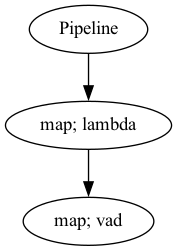

In [7]:
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

Starting malaya-speech 1.4.0, streaming always returned a float32 array between -1 and +1 values.

### Streaming interface

```python
def stream(
    vad_model=None,
    asr_model=None,
    classification_model=None,
    sample_rate: int = 16000,
    segment_length: int = 2560,
    num_padding_frames: int = 20,
    ratio: float = 0.75,
    min_length: float = 0.1,
    max_length: float = 10.0,
    realtime_print: bool = True,
    **kwargs,
):
    """
    Stream an audio using pyaudio library.

    Parameters
    ----------
    vad_model: object, optional (default=None)
        vad model / pipeline.
    asr_model: object, optional (default=None)
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object, optional (default=None)
        classification pipeline, will classify each subsamples realtime.
    device: None, optional (default=None)
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    segment_length: int, optional (default=2560)
        usually derived from asr_model.segment_length * asr_model.hop_length,
        size of audio chunks, actual size in term of second is `segment_length` / `sample_rate`.
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (second) to accept a subsample.
    max_length: float, optional (default=10.0)
        maximum length (second) to accept a subsample.
    realtime_print: bool, optional (default=True)
        Will print results for ASR.
    **kwargs: vector argument
        vector argument pass to malaya_speech.streaming.pyaudio.Audio interface.

    Returns
    -------
    result : List[dict]
    """
```

### Start Recording

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [10]:
samples = malaya_speech.streaming.pyaudio.stream(vad_model = p_vad, segment_length = 320)

In [11]:
len(samples)

3

In [14]:
samples[0]

{'wav_data': array([0.0005531 , 0.00187427, 0.00227408, ..., 0.00623526, 0.00693975,
        0.00602183], dtype=float32),
 'start': 0.0,
 'end': 6.8}

In [13]:
import IPython.display as ipd

In [15]:
ipd.Audio(samples[0]['wav_data'], rate = 16000)

In [16]:
ipd.Audio(samples[1]['wav_data'], rate = 16000)

In [17]:
ipd.Audio(samples[2]['wav_data'], rate = 16000)

### Post script

You guys can hear my wife and my kid arguing each other at the background 😅.